In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from numba import njit

@njit
def initialize_agents(lattice_size, num_agents, initial_infection_rate):
    num_infected = int(num_agents * initial_infection_rate)
    agents = np.zeros((num_agents, 3), dtype=np.int32)

    # Create a shuffled array of indices
    indices = np.arange(num_agents)
    np.random.shuffle(indices)

    for i in range(num_agents):
        agents[i, 0] = np.random.randint(0, lattice_size)
        agents[i, 1] = np.random.randint(0, lattice_size)
        # Infect a random 1% of the agents, based on the indices shuffled
        agents[i, 2] = 1 if i in indices[:num_infected] else 0
    
    return agents

@njit
def move_agents(agents, lattice_size, diffusion_rate):
    for i in range(agents.shape[0]):
        if np.random.random() < diffusion_rate:
            move_x = np.random.randint(-1, 2)
            move_y = np.random.randint(-1, 2)
            agents[i, 0] = (agents[i, 0] + move_x) % lattice_size
            agents[i, 1] = (agents[i, 1] + move_y) % lattice_size

@njit
def infect_agents(agents, beta, lattice_size):
    for i in range(agents.shape[0]):
        if agents[i, 2] == 1:
            for j in range(agents.shape[0]):
                if agents[j, 2] == 0 and agents[i, 0] == agents[j, 0] and agents[i, 1] == agents[j, 1]:
                    if np.random.random() < beta:
                        agents[j, 2] = 1

@njit
def update_recovery(agents, gamma):
    for i in range(agents.shape[0]):
        if agents[i, 2] == 1 and np.random.random() < gamma:
            agents[i, 2] = 2

@njit
def update_death(agents, mu):
    for i in range(agents.shape[0]):
        # Check if agent infected
        if agents[i, 2] == 1 and np.random.random() < mu:
            agents[i, 2] = 3  # state 3 = dead   
            
            
@njit
def update_agents(agents, lattice_size, diffusion_rate, beta, gamma, mu):
    move_agents(agents, lattice_size, diffusion_rate)
    infect_agents(agents, beta, lattice_size)
    update_recovery(agents, gamma)
    update_death(agents, mu)

In [2]:
# Simulation params
lattice_size = 100
num_agents = 1000
diffusion_rate = 0.8  # Diffusion rate, probability to move
total_time_steps = 2000
initial_infection_rate = 0.01

In [3]:
@njit
def run_simulation(beta, gamma, mu):
    # Initialize agents
    agents = initialize_agents(lattice_size, num_agents, initial_infection_rate)

    # Lists to track the number of S, I, R
    susceptible_count = []
    infected_count = []
    recovered_count = []
    dead_count = []

    # Run Simulation & Count SIR States
    for step in range(total_time_steps + 1):
        state_count = np.bincount(agents[:, 2], minlength=4)
        susceptible_count.append(state_count[0])
        infected_count.append(state_count[1])
        recovered_count.append(state_count[2])
        dead_count.append(state_count[3])
        update_agents(agents, lattice_size, diffusion_rate, beta, gamma, mu)

    return susceptible_count, infected_count, recovered_count, dead_count

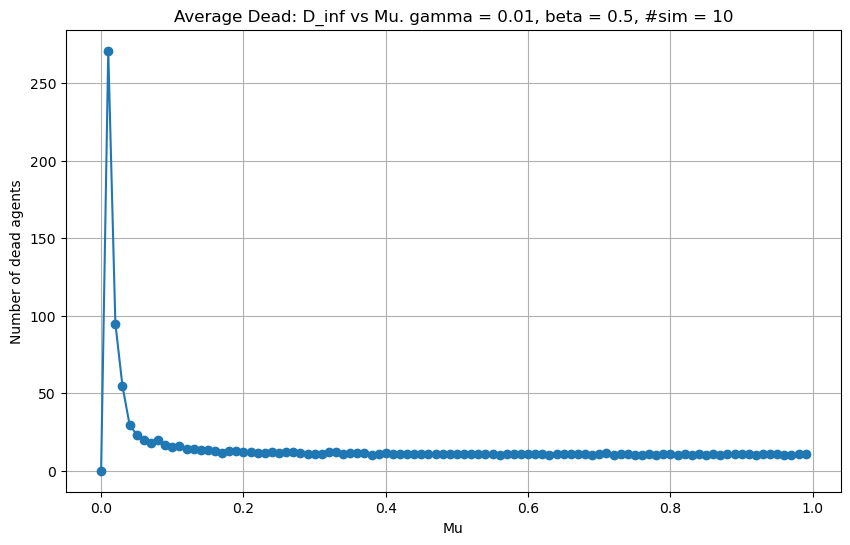

In [4]:
beta = 0.6      # Infection rate
gamma = 0.01    # Recovery rate
mu_range = np.arange(0, 1, 0.01)
num_sim = 10

number_dead = []

for mu in mu_range:
    total_max_dead = 0
    for _ in range(num_sim):
        susceptible, infected, recovered, dead  = run_simulation(beta, gamma, mu)
        total_max_dead += max(dead)
    total_max_dead = total_max_dead / num_sim
    number_dead.append(total_max_dead)


plt.figure(figsize=(10, 6))
plt.plot(mu_range, number_dead, marker='o', linestyle='-')
plt.title('Average Dead: D_inf vs Mu. gamma = 0.01, beta = 0.5, #sim = 10')
plt.xlabel('Mu')
plt.ylabel('Number of dead agents')
plt.grid(True)
plt.show()

If mu very high, sick people die quick and therefore no more sick people remain.

Max D_inf: 19.6 at mu: 0.01 for beta: 0.2 and gamma: 0.01
Max D_inf: 11.7 at mu: 0.02 for beta: 0.2 and gamma: 0.02
Max D_inf: 10.4 at mu: 0.48 for beta: 0.2 and gamma: 0.03
Max D_inf: 133.4 at mu: 0.01 for beta: 0.4 and gamma: 0.01
Max D_inf: 18.3 at mu: 0.02 for beta: 0.4 and gamma: 0.02
Max D_inf: 12.2 at mu: 0.05 for beta: 0.4 and gamma: 0.03
Max D_inf: 286.5 at mu: 0.01 for beta: 0.6 and gamma: 0.01
Max D_inf: 47.9 at mu: 0.01 for beta: 0.6 and gamma: 0.02
Max D_inf: 17.7 at mu: 0.03 for beta: 0.6 and gamma: 0.03
Max D_inf: 353.1 at mu: 0.01 for beta: 0.8 and gamma: 0.01
Max D_inf: 87.1 at mu: 0.01 for beta: 0.8 and gamma: 0.02
Max D_inf: 22.8 at mu: 0.01 for beta: 0.8 and gamma: 0.03
Max D_inf: 404.0 at mu: 0.01 for beta: 1 and gamma: 0.01
Max D_inf: 117.2 at mu: 0.01 for beta: 1 and gamma: 0.02
Max D_inf: 37.6 at mu: 0.02 for beta: 1 and gamma: 0.03


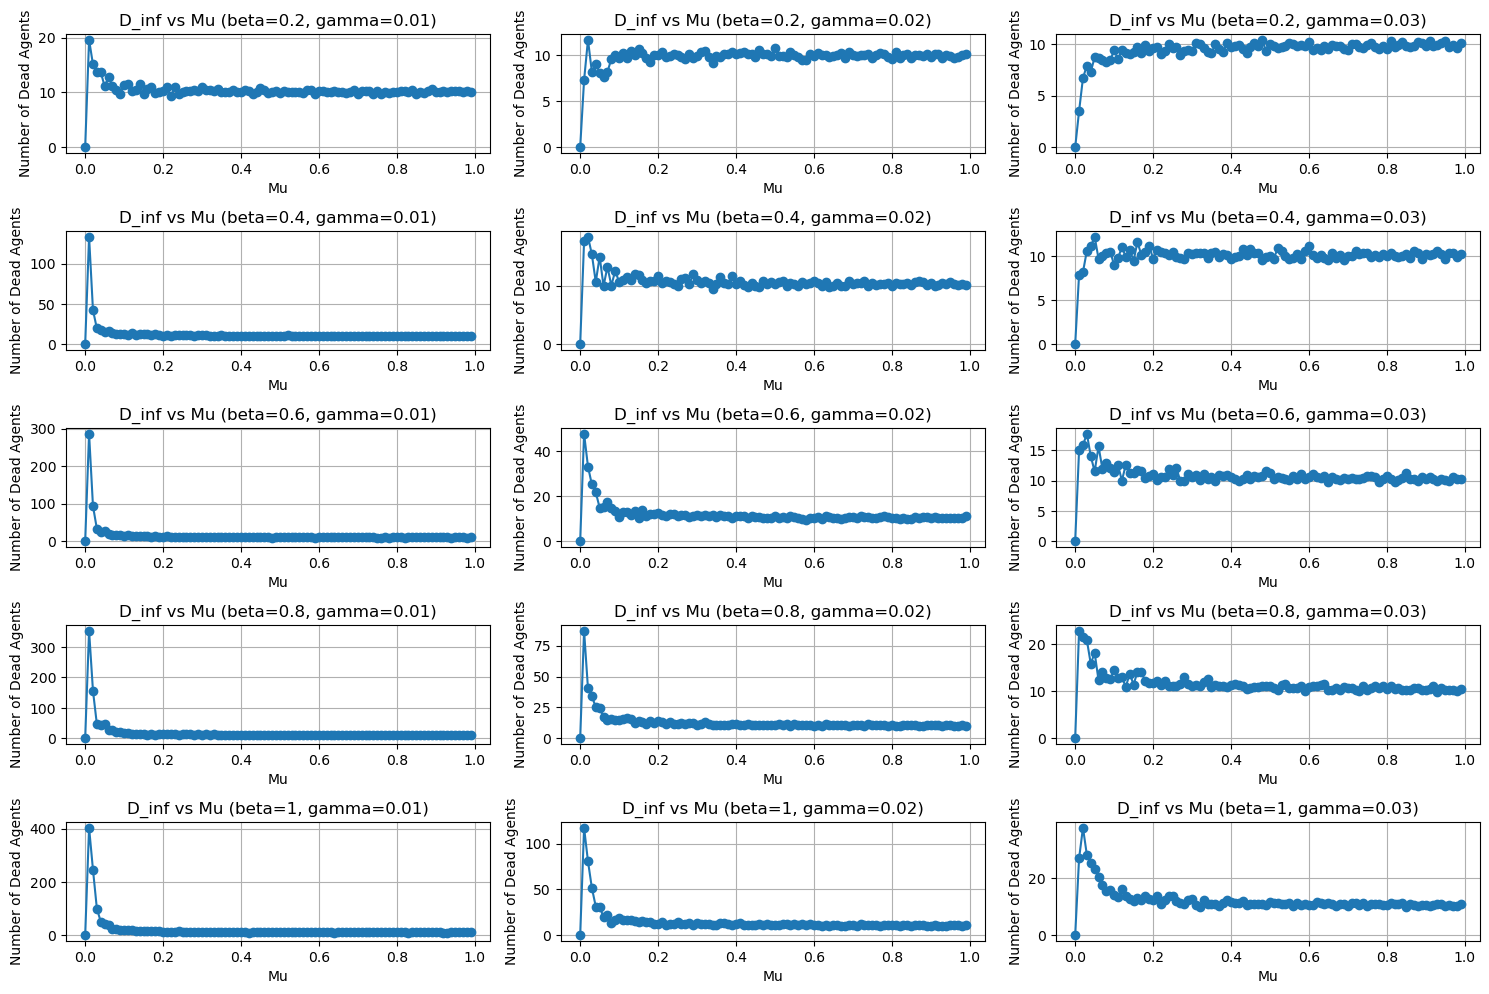

In [7]:
beta_values = [0.2, 0.4, 0.6, 0.8, 1]
gamma_values = [0.01, 0.02, 0.03]
mu_range = np.arange(0, 1, 0.01)
num_sim = 10

plt.figure(figsize=(15, 10))

for i, beta in enumerate(beta_values):
    for j, gamma in enumerate(gamma_values):
        number_dead = []
        
        for mu in mu_range:
            total_max_dead = 0
            for _ in range(num_sim):
                susceptible, infected, recovered, dead = run_simulation(beta, gamma, mu)
                total_max_dead += max(dead)
            total_max_dead = total_max_dead / num_sim
            number_dead.append(total_max_dead)
        
        # Find max D_inf and corresponding mu
        max_dead = max(number_dead)
        max_mu = mu_range[number_dead.index(max_dead)]

        # Print max D_inf and corresponding mu
        print(f"Max D_inf: {max_dead} at mu: {max_mu} for beta: {beta} and gamma: {gamma}")

        # Plot
        plt.subplot(len(beta_values), len(gamma_values), i * len(gamma_values) + j + 1)
        plt.plot(mu_range, number_dead, marker='o', linestyle='-')
        plt.title(f'D_inf vs Mu (beta={beta}, gamma={gamma})')
        plt.xlabel('Mu')
        plt.ylabel('Number of Dead Agents')
        plt.grid(True)

plt.tight_layout()
plt.show()